Arpitha Gurumurthy </br>
Team: Amalgam
# **Automated Inference Pipeline**
### **Factor: Style Based approaches for fake news detection**
There are mainly two typical categories of style-based
methods: 
* Deception-oriented
* Objectivity-oriented
  * hyperpartisan styles and yellow-journalism.



**Micro factors chosen:**
* Hyperpartisan: Extremely one sided
* Yellow Journalism: relying on eye-catching headlines
* Deception/Lying in text (Implementing as part of Rhetoric structure)

**Information on dates for the datasets.**
* Yellow Jounalism - used politifact dataset for dates 2020-07-01 to 2021-04-08
* Deception detection- Kaggle fake news dataset: https://www.kaggle.com/surekharamireddy/fake-news-detection
* Hyperpartisan - SemEval Hyperpartisan News Detection task dataset for dates ('1902-02-01') - ('2018-08-28')
https://pan.webis.de/semeval19/semeval19-web/

## **Pre-requisites**
Installing required libraries and scraping data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Pickle_Models

/content/gdrive/My Drive/Pickle_Models


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install newspaper3k

     |████████████████████████████████| 215kB 8.0MB/s 
     |████████████████████████████████| 7.4MB 8.5MB/s 
     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 92kB 6.1MB/s 
  Created wheel for jieba3k: filename=jieba3k-0.35.1-cp37-none-any.whl size=7398406 sha256=ebb7dd461351e0cb4e57d629b297177a778b125db87c74ddf1c4d6b1343d32ac
  Stored in directory: /root/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35da20627c013f438ed34
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-cp37-none-any.whl size=3358 sha256=00dcb5ad5f997dcf21509a09666aaa9419ccac17508b9a1c58dfb271a0fe2463
  Stored in directory: /root/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c7575424cfd3340f40ed
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-cp37-none-any.whl size=13538 sha256=f4b169dc70310c953c39de0758c4bdf1f051a0bca92481daad5b338a4416d57d
  Stored in directory: /root/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c771

In [ ]:
pip install textstat

     |████████████████████████████████| 102kB 3.7MB/s 
     |████████████████████████████████| 1.9MB 9.2MB/s 


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## **Scraping Yahoo news**

In [ ]:
import re
import csv
from time import sleep
from bs4 import BeautifulSoup
import requests
import sys
from newspaper import Article
import pandas as pd

headers = {
    'accept': '*/*',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.9',
    'referer': 'https://www.google.com',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.83 Safari/537.36 Edg/85.0.564.44'
}

def get_article(card):
    """Extract article information from the raw html"""
    headline = card.find('h4', 's-title').text
    source = card.find("span", 's-source').text
    posted = card.find('span', 's-time').text.replace('·', '').strip()
    #description = card.find('p', 's-desc').text.strip()
    raw_link = card.find('a').get('href')
    unquoted_link = requests.utils.unquote(raw_link)
    pattern = re.compile(r'RU=(.+)\/RK')
    clean_link = re.search(pattern, unquoted_link).group(1)
    #Creating an instance of the article
    parsed_article = Article(clean_link, language="en")
    #To download the article
    try:
      parsed_article.download()
      #To parse the article
      parsed_article.parse()
      #To perform natural language processing ie..nlp
      parsed_article.nlp()
    except:
      e = sys.exc_info()[0]
    article = (headline, source, posted, clean_link, parsed_article.summary)
    return article

def get_the_news(search):
    """Run the main program"""
    template = 'https://news.search.yahoo.com/search?p={}'
    url = template.format(search)
    articles = []
    links = set()
    
    for i in range(3):
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        cards = soup.find_all('div', 'NewsArticle')
        
        # extract articles from page
        for card in cards:
            article = get_article(card)
            link = article[-1]
            if not link in links:
                links.add(link)
                articles.append(article)        
                
        try:
            url = soup.find('a', 'next').get('href')
            sleep(1)
        except AttributeError:
            continue
            
    # save article data
    with open('results_streaming.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Headline', 'Source', 'Posted', 'Link', 'Summary'])
        writer.writerows(articles)
        
    return articles

In [ ]:
results_streaming_df = pd.read_csv('results_streaming.csv')
results_streaming_df.head()

,Headline,Source,Posted,Link,Summary
0,Latest reopening sign: The New York Stock Exch...,Axios via Yahoo News,4 hours ago,https://news.yahoo.com/latest-reopening-sign-y...,“Today is a milestone for New York state and a...
1,"District baseball, softball tournaments: All t...",Idaho Statesman via Yahoo News,2 hours ago,https://news.yahoo.com/district-baseball-softb...,"What he's saying: ""I think I was being extreme..."
2,Tapering of bond purchases in focus as Bank of...,Yahoo Finance UK,2 hours ago,https://www.yahoo.com/finance/news/tapering-of...,"Odds show a repeat of the 2014 referendum, whe..."
3,"The Latest: PGA'S Todd tests positive, out of ...",San Francisco Chronicle,7 hours ago,https://www.sfgate.com/sports/article/The-Late...,The Latest on the effects of the coronavirus o...
4,The latest hockey player to enter the realm of...,ESPN,14 hours ago,https://www.espn.com/nhl/story/_/id/31383777/h...,Hall of Famer Bryan Trottier reflects on his e...


# Yellow-Factor

## **Creating latent variables for calculating yellowness factor**

* **flesch_reading_ease** : tells us how convoluted the sentence is. The more confusing the sentence is, the more is its yellowness. We divide the value by 10 and add it towards the yellowness score.
* **is_q** : Tells us whether the text contains a question. More the questions, more the yellowness. This features gets a weight of 5.
* **is_exclam** : Tells us whether the text contains an exclamation. This features gets a weight of 10.
* **is_money** : Tells us whether the text has money relation information. This features gets a weight of 5.
* **starts_num** : Tells us whether if the text start with a number. This features gets a weight of 5.
* **All_Caps** : Tells us whether if the text contains all uppercase words. This features gets a weight of 20, since it depicts sensationalism.
* **Sentiment_Score** : A lot of emotion is captured in sensationalized text. We take the magnitude (postive and negative) of this score and add it to yellowness score.


In [ ]:
#function to find if string contains a question and if so, create new feature with a 1 for yes or 0 for no
question_words = ['who','what','where','why','when','whose','whom','would','will','how','which','should','could']

def is_question(text):
    if "?" in text or text.startswith(('who','what','where','why','when','whose','whom','would','will','how','which','should','could','did','do')):
        return 1
    else: 
        return 0

In [ ]:
#create function to find if headline contains '!' and create new feature with 1 for yes and 0 for no
def is_exclamation(headline):
    if "!" in headline: 
        return 1
    else: 
        return 0

In [ ]:
#create function to find if headline contains '$' and create new feature with 1 for yes and 0 for no
def is_money_related(headline):
    if "$" in headline: 
        return 1
    else: 
        return 0

In [ ]:
#create function to find if headline starts with a digit and create new feature with 1 for yes and 0 for no
def starts_with_num(text):
    if text.startswith(('1','2','3','4','5','6','7','8','9')): 
        return 1
    else: 
        return 0

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

def yellowness_preprocessing(yellow_preprocess_df):
  
  print("Starting preprocessing for yellowness factor on our text..")
  yellow_preprocess_df.Summary = yellow_preprocess_df.Summary.apply(str)

  ##Creating a feature to score the text with a readability factor
  yellow_preprocess_df['flesch'] = yellow_preprocess_df['Summary'].apply(textstat.flesch_reading_ease)
  ##Since the flesch reading score is now inversely proportional to the yellowness factor
  ##we substract its value from the highest - 121.22
  yellow_preprocess_df['flesch'] = 121.22 - yellow_preprocess_df['flesch'] 

  #function to find if string contains a question and if so, create new feature with a 1 for yes or 0 for no
  yellow_preprocess_df['text_lower']=yellow_preprocess_df['Summary'].apply(lambda x: x.lower())
  yellow_preprocess_df['is_q']=yellow_preprocess_df['text_lower'].apply(is_question)
  yellow_preprocess_df = yellow_preprocess_df.drop(columns='text_lower')

  #create function to find if headline contains '!' and create new feature with 1 for yes and 0 for no
  yellow_preprocess_df['is_exclam']=yellow_preprocess_df['Summary'].apply(is_exclamation)

  #create function to find if headline contains '$' and create new feature with 1 for yes and 0 for no
  yellow_preprocess_df['is_money']=yellow_preprocess_df['Summary'].apply(is_money_related)

  #create function to find if headline starts with a digit and create new feature with 1 for yes and 0 for no
  yellow_preprocess_df['starts_num']=yellow_preprocess_df['Summary'].apply(starts_with_num)

  ##Calculating the number of words in each Summary 
  yellow_preprocess_df['num_words'] = yellow_preprocess_df['Summary'].apply(lambda x: len(x.split()))

  ##Creating a new feature to store the number of ALL CAPS words in each Summary
  yellow_preprocess_df['All_Caps'] = yellow_preprocess_df['Summary'].apply(lambda x: sum(map(str.isupper, x.split())))

  ##Looping to pass every headline into the analyser, a sentiment score is assigned to each headline.
  sia = SIA()
  results = []
  for headline in yellow_preprocess_df['Summary']:
      pol_score = sia.polarity_scores(headline)
      pol_score['headline'] = headline
      results.append(pol_score)
  ##Concatenating this list to our original dataframe, only interested in the values of the ‘compound’ variable.
  yellow_preprocess_df['Sentiment_Score'] = pd.DataFrame(results)['compound']                                

  print('Yellowness factor preprocessing done!!')
  
  ##Convert preprocessed df to csv
  yellow_preprocess_df.to_csv('yellow_preprocess_df.csv')


## **Loading the model for yellowness**

In [ ]:
def invoke_modeling_yellowness():
  yellow_preprocess_df = pd.read_csv('yellow_preprocess_df.csv')
  X_test = yellow_preprocess_df[['flesch','is_q','is_exclam','is_money','starts_num','All_Caps','num_words','Sentiment_Score']]
  # Y_test = yellow_preprocess_df[['yellow_factor']]
  yellowness_preds = []
  yellowness_model = pickle.load( open( "finalized_model_1.sav", "rb" ) )
  yellowness_preds = yellowness_model.predict(X_test)
  print(yellowness_preds)
  yellow_preprocess_df['yellow_factor'] = yellowness_preds
  yellow_preprocess_df.to_csv('yellow_preprocess_df_with_preds.csv')

  # result = yellowness_model.score(X_test, Y_test)
  # print(result)
  
  print("loading done")

# Deception-Factor

## **Creating latent variables for Deception Factor**
* avg_sentence_length: tells us the average number of words in each sentence of the text. 
* avg_syllables: tells us the average number of syllables in each word of the text.
* Sentiment_Score: We take the magnitude (postive and negative) of this score and add it to deception score.
* flesch_kincaid_grade: It shows the required education to be able to understand a text. Text intended for readership by the general public should aim for a grade level of around 8, schooling age 13 to 14
* gunning_fog: The principle behind the Gunning Fog Index formula is that short sentences written in plain English receive a better score than longer sentences written in complex language


In [ ]:
%cd /content/gdrive/My Drive/Pickle_Models

/content/gdrive/My Drive/Pickle_Models


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

def deception_preprocessing(preprocess_df):
  
  print("Starting preprocessing for deception factor on our text..")
  preprocess_df.Summary = preprocess_df.Summary.apply(str)

  ##Creating a feature to count the number of words
  preprocess_df['lex_count'] = preprocess_df['Summary'].apply(textstat.lexicon_count)

  ##Creating a feature to count the number of difficult words
  # preprocess_df['difficult_count'] = preprocess_df['Summary'].apply(textstat.difficult_words)

  ##Creating a feature to count the number of sentences
  preprocess_df['num_sentences'] = preprocess_df['Summary'].apply(textstat.sentence_count)

  ##Creating a feature to count the number of syllable
  preprocess_df['num_syllables'] = preprocess_df['Summary'].apply(textstat.syllable_count)

  ##Creating a feature for flesch_kincaid_grade
  preprocess_df['flesch_kincaid_grade'] = preprocess_df['Summary'].apply(textstat.flesch_kincaid_grade)

  ##The Fog Scale (Gunning FOG Formula)
  preprocess_df['gunning_fog'] = preprocess_df['Summary'].apply(textstat.gunning_fog)

  ##Creating a feature for avg number of syllables per word - 
  preprocess_df['avg_syllables'] = preprocess_df['num_syllables'] / preprocess_df['lex_count']

  ## Average sentence length
  preprocess_df['avg_sentence_length'] = preprocess_df['lex_count'] / preprocess_df['num_sentences']

  ##Looping to pass every headline into the analyser, a sentiment score is assigned to each headline.
  sia = SIA()
  results = []
  for headline in preprocess_df['Summary']:
      pol_score = sia.polarity_scores(headline)
      pol_score['headline'] = headline
      results.append(pol_score)

  ##Concatenating this list to our original dataframe, only interested in the values of the ‘compound’ variable.
  preprocess_df['Sentiment_Score'] = pd.DataFrame(results)['compound']

  print('Preprocessing done!!')
  print(preprocess_df)

  preprocess_df.to_csv('deception_preprocess_df.csv')
  

## **Loading the model for deception score**

In [ ]:
def invoke_modeling():
  deception_preprocess_df = pd.read_csv('deception_preprocess_df.csv')
  X_test = deception_preprocess_df[['avg_sentence_length','avg_syllables','flesch_kincaid_grade','gunning_fog','Sentiment_Score']]
  # Y_test = deception_preprocess_df[['deceptiveness_factor']]
  deception_preds = []
  deception_model = pickle.load( open( "deception_model.sav", "rb" ) )
  deception_preds = deception_model.predict(X_test)
  print(deception_preds)
  deception_preprocess_df['deceptiveness_factor'] = deception_preds
  print(deception_preprocess_df)
  deception_preprocess_df.to_csv('deception_preprocess_df_with_preds.csv')
  # result = deception_model.score(X_test, Y_test)
  # print(result)
  print("loading done")

# Hyperpartisan

## **Data preparation**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from nltk.corpus import stopwords

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def read_glove(path, dim):
    '''
    read the glove vectors from path with dimension dim
    '''
    df = pd.read_csv(path + 'glove.6B.' + str(dim) + 'd.txt', sep=" ", quoting=3, header=None, index_col=0)
    glove = {key: val.values for key, val in df.T.items()}
    return glove

def gloveVectorize(glove, text):
    '''
    Find the pretrained glove vectors of the first 1000 words in the articles.
    The final vector is the average of the vectors
    '''
    dim = len(glove["the"])
    X = np.zeros( (len(text), dim) )
    for text_id, t in enumerate(text):
        tmp = np.zeros((1, dim))
        
        # tokenize and remove stopwords
        words = customTokenize(t, rm_stopwords=True)
        words = [w for w in words if w in glove.keys()]
        for word in words:
            tmp[:] += glove[word]
        X[text_id, :] = tmp/len(words)
    return X

def customTokenize(text, rm_stopwords=False):
    '''
    lower, strip numbers and punctuation, remove stop words
    '''
    tokens = nltk.word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    words = [word for word in tokens if word.isalpha()]
    if rm_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
    return words
  

In [ ]:
def hyperpartisan_preprocessing(hyperpartisan_df):
  hyperpartisan_df = hyperpartisan_df.dropna()
  print("Starting preprocessing for detecting hyperpartisan")
  ##Convert to array
  hyperpartisan_df.Summary = hyperpartisan_df.Summary.apply(str)
  ##Remove html tags
  hyperpartisan_df['Summary'] = hyperpartisan_df['Summary'].apply(remove_html_tags)
  ##Convert to array
  text_array = hyperpartisan_df['Summary'].to_numpy()
  # set path for data
  pretrained_wv_path = "Glove/"
  # read in data and glove vectors
  glove = read_glove(pretrained_wv_path, 50)
  ##Vectorizing our text
  glove_texts = gloveVectorize(glove, text_array)
  test_x = glove_texts

  ##Modeling
  hyperpartisan_model = pickle.load( open( "SVM_Glove.sav", "rb" ) )
  ##Making predictions
  hyperpartisan_preds = hyperpartisan_model.predict(test_x)
  print(hyperpartisan_preds)

  hyperpartisan_df['hyperpartisan'] = hyperpartisan_preds
  hyperpartisan_df.to_csv('hyperpartisan_df.csv')

# **Predicting deception score and yellow score on streaming data**

## **Pipeline for yellowness and deception factor**

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import functools
import textstat
import pickle
from sklearn.pipeline import Pipeline

button = widgets.Button(description="Get Feed")
output = widgets.Output()

def pipeline_deception(streaming_df):
  model = Pipeline([
    ('preprocessing', deception_preprocessing(streaming_df)),
    ('mlp', invoke_modeling()),
  ])

def pipeline_yellowness(streaming_df):
  model = Pipeline([
    ('yellowness_preprocessing', yellowness_preprocessing(streaming_df)),
    ('mlp', invoke_modeling_yellowness())
  ])

##On clicking the button
def on_button_clicked(b):

  print("Fetching data.. please wait!")
  news_list = ["latest"]
  for news in news_list:
      ##Invoke function 'get_the_news'
      articles_final = get_the_news(news)
  print('fetching data done!!')
  ##Reading the above created csv with latest news
  streaming_df = pd.read_csv('results_streaming.csv')
  pipeline_deception(streaming_df)
  pipeline_yellowness(streaming_df)
  # streaming_df = streaming_df.dropna()
  # hyperpartisan_preprocessing(streaming_df)

button.on_click(on_button_clicked)
display(button, output)

Button(description='Get Feed', style=ButtonStyle())

Output()

Fetching data.. please wait!
fetching data done!!
Starting preprocessing for deception factor on our text..
Preprocessing done!!
                                             Headline  ... Sentiment_Score
0   Latest reopening sign: The New York Stock Exch...  ...          0.4767
1   The latest numbers on COVID-19 in Canada for T...  ...          0.0000
2   Latest hearing in High Court battle between Me...  ...          0.8625
3   District baseball, softball tournaments: All t...  ...         -0.3182
4   The Latest: PGA'S Todd tests positive, out of ...  ...          0.8779
5   Tapering of bond purchases in focus as Bank of...  ...          0.7650
6   The latest hockey player to enter the realm of...  ...          0.7650
7   Morrison's latest announcement has disgusted s...  ...          0.3612
8   Chris Weidman shares latest health update afte...  ...         -0.8070
9   The Latest: Detroit going door-to-door to enco...  ...          0.0000
10  The Latest: Belmont Stakes to have at leas

In [ ]:
streaming_df = pd.read_csv('results_streaming.csv')
streaming_df.shape
hyperpartisan_preprocessing(streaming_df)

Starting preprocessing for detecting hyperpartisan
[False False False False False False False False False False False False
 False False False False False False False False False]


# Ensembling

## **method: polynomial**

In [ ]:
deception_df = pd.read_csv('deception_preprocess_df_with_preds.csv')
yellow_df = pd.read_csv('yellow_preprocess_df_with_preds.csv')
deception_df = deception_df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
yellow_df = yellow_df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
hyperpartisan_df = pd.read_csv('hyperpartisan_df.csv')
hyperpartisan_df = hyperpartisan_df.drop(columns=['Unnamed: 0'], axis = 1)

In [ ]:
hyperpartisan_df.shape

(7, 6)

In [ ]:
yellow_df.shape

(8, 21)

In [ ]:
deception_df.shape

(8, 14)

In [ ]:
# ##Creating a df for prediction
# ensemble_df = deception_df[['Headline', 'Source','Posted','Link','Summary','deceptiveness_factor']]
# ensemble_df['yellow_factor'] = yellow_df['yellow_factor']

In [ ]:
##Creating a df with latent manifold for visualization purposes
ensemble_df_detailed = pd.merge(deception_df, yellow_df,  on = ['Posted','Link','Summary','Headline','Source','Sentiment_Score'])

In [ ]:
ensemble_df_detailed = pd.merge(hyperpartisan_df, ensemble_df_detailed, on = ['Headline'])

In [ ]:
ensemble_df_detailed.shape

(7, 34)

In [ ]:
ensemble_df_detailed['deceptiveness_factor'].replace(
    {
        'Not Deceptive': 0,
        'Deceptive': 1
    }, inplace = True
)

In [ ]:
ensemble_df_detailed['yellow_factor'].replace(
    {
        'Least yellow': 0,
        'Moderately Yellow': 1,
        'Highly yellow': 2
    }, inplace = True
)

In [ ]:
ensemble_df_detailed.head()

,Headline,Source_x,Posted_x,Link_x,Summary_x,hyperpartisan,Source_y,Posted_y,Link_y,Summary_y,lex_count_x,num_sentences_x,num_syllables_x,flesch_kincaid_grade_x,gunning_fog_x,avg_syllables_x,avg_sentence_length_x,Sentiment_Score,deceptiveness_factor,lex_count_y,num_sentences_y,num_syllables_y,flesch_kincaid_grade_y,gunning_fog_y,avg_syllables_y,avg_sentence_length_y,flesch,is_q,is_exclam,is_money,starts_num,num_words,All_Caps,yellow_factor
0,"The Latest: PGA'S Todd tests positive, out of ...",San Francisco Chronicle,3 hours ago,https://www.sfgate.com/sports/article/The-Late...,The Latest on the effects of the coronavirus o...,False,San Francisco Chronicle,3 hours ago,https://www.sfgate.com/sports/article/The-Late...,The Latest on the effects of the coronavirus o...,110,5,162,10.7,12.07,1.472727,22.000000,0.8779,1,110,5,162,10.7,12.07,1.472727,22.000000,63.61,0,0,0,0,110,0,0
1,The latest hockey player to enter the realm of...,ESPN,11 hours ago,https://www.espn.com/nhl/story/_/id/31383777/h...,Hall of Famer Bryan Trottier reflects on his e...,False,ESPN,11 hours ago,https://www.espn.com/nhl/story/_/id/31383777/h...,Hall of Famer Bryan Trottier reflects on his e...,82,3,118,11.6,14.33,1.439024,27.333333,0.7650,1,82,3,118,11.6,14.33,1.439024,27.333333,60.53,1,0,0,0,82,1,0
2,Morrison's latest announcement has disgusted s...,MSN News,5 hours ago,https://www.msn.com/en-gb/news/newsbirmingham/...,"This site uses cookies for analytics, personal...",False,MSN News,5 hours ago,https://www.msn.com/en-gb/news/newsbirmingham/...,"This site uses cookies for analytics, personal...",21,2,34,7.4,9.91,1.619048,10.500000,0.3612,1,21,2,34,7.4,9.91,1.619048,10.500000,60.40,0,0,0,0,21,0,1
3,Chris Weidman shares latest health update afte...,BJPenn.com,7 hours ago,https://www.bjpenn.com/mma-news/ufc/chris-weid...,Former UFC middleweight champion Chris Weidman...,False,BJPenn.com,7 hours ago,https://www.bjpenn.com/mma-news/ufc/chris-weid...,Former UFC middleweight champion Chris Weidman...,126,5,182,10.8,12.62,1.444444,25.200000,-0.8070,1,126,5,182,10.8,12.62,1.444444,25.200000,58.40,0,0,0,0,126,3,0
4,"Elden Ring Latest Leaked Footage Is Not Real, ...",Wccftech,10 hours ago,https://wccftech.com/elden-ring-latest-leaked-...,The latest Elden Ring leaked footage is appare...,False,Wccftech,10 hours ago,https://wccftech.com/elden-ring-latest-leaked-...,The latest Elden Ring leaked footage is appare...,99,5,131,7.5,9.94,1.323232,19.800000,-0.6705,1,99,5,131,7.5,9.94,1.323232,19.800000,44.46,0,0,0,0,99,1,0


In [ ]:
ensemble_df_detailed['hyperpartisan'] = ensemble_df_detailed['hyperpartisan'].apply(lambda x:int(x == 'true')) 

In [ ]:
ensemble_df_detailed['hyperpartisan']

0    0
1    0
2    0
3    0
4    0
5    0
6    0
Name: hyperpartisan, dtype: int64

**Applying a weighted average based on accuracy**

In [ ]:
##Applying a simple ensemble 
ensemble_df_detailed['badStyle_score'] = ensemble_df_detailed['deceptiveness_factor']*0.4 + ensemble_df_detailed['yellow_factor']*0.4 + ensemble_df_detailed['hyperpartisan']*0.2 

In [ ]:
ensemble_df_detailed.head()

,Headline,Source_x,Posted_x,Link_x,Summary_x,hyperpartisan,Source_y,Posted_y,Link_y,Summary_y,lex_count_x,num_sentences_x,num_syllables_x,flesch_kincaid_grade_x,gunning_fog_x,avg_syllables_x,avg_sentence_length_x,Sentiment_Score,deceptiveness_factor,lex_count_y,num_sentences_y,num_syllables_y,flesch_kincaid_grade_y,gunning_fog_y,avg_syllables_y,avg_sentence_length_y,flesch,is_q,is_exclam,is_money,starts_num,num_words,All_Caps,yellow_factor,badStyle_score
0,"The Latest: PGA'S Todd tests positive, out of ...",San Francisco Chronicle,3 hours ago,https://www.sfgate.com/sports/article/The-Late...,The Latest on the effects of the coronavirus o...,0,San Francisco Chronicle,3 hours ago,https://www.sfgate.com/sports/article/The-Late...,The Latest on the effects of the coronavirus o...,110,5,162,10.7,12.07,1.472727,22.000000,0.8779,1,110,5,162,10.7,12.07,1.472727,22.000000,63.61,0,0,0,0,110,0,0,0.4
1,The latest hockey player to enter the realm of...,ESPN,11 hours ago,https://www.espn.com/nhl/story/_/id/31383777/h...,Hall of Famer Bryan Trottier reflects on his e...,0,ESPN,11 hours ago,https://www.espn.com/nhl/story/_/id/31383777/h...,Hall of Famer Bryan Trottier reflects on his e...,82,3,118,11.6,14.33,1.439024,27.333333,0.7650,1,82,3,118,11.6,14.33,1.439024,27.333333,60.53,1,0,0,0,82,1,0,0.4
2,Morrison's latest announcement has disgusted s...,MSN News,5 hours ago,https://www.msn.com/en-gb/news/newsbirmingham/...,"This site uses cookies for analytics, personal...",0,MSN News,5 hours ago,https://www.msn.com/en-gb/news/newsbirmingham/...,"This site uses cookies for analytics, personal...",21,2,34,7.4,9.91,1.619048,10.500000,0.3612,1,21,2,34,7.4,9.91,1.619048,10.500000,60.40,0,0,0,0,21,0,1,0.8
3,Chris Weidman shares latest health update afte...,BJPenn.com,7 hours ago,https://www.bjpenn.com/mma-news/ufc/chris-weid...,Former UFC middleweight champion Chris Weidman...,0,BJPenn.com,7 hours ago,https://www.bjpenn.com/mma-news/ufc/chris-weid...,Former UFC middleweight champion Chris Weidman...,126,5,182,10.8,12.62,1.444444,25.200000,-0.8070,1,126,5,182,10.8,12.62,1.444444,25.200000,58.40,0,0,0,0,126,3,0,0.4
4,"Elden Ring Latest Leaked Footage Is Not Real, ...",Wccftech,10 hours ago,https://wccftech.com/elden-ring-latest-leaked-...,The latest Elden Ring leaked footage is appare...,0,Wccftech,10 hours ago,https://wccftech.com/elden-ring-latest-leaked-...,The latest Elden Ring leaked footage is appare...,99,5,131,7.5,9.94,1.323232,19.800000,-0.6705,1,99,5,131,7.5,9.94,1.323232,19.800000,44.46,0,0,0,0,99,1,0,0.4


**We now have a badStyle_score which tells us the scale of bad style present in text.**

# Visualizing our results

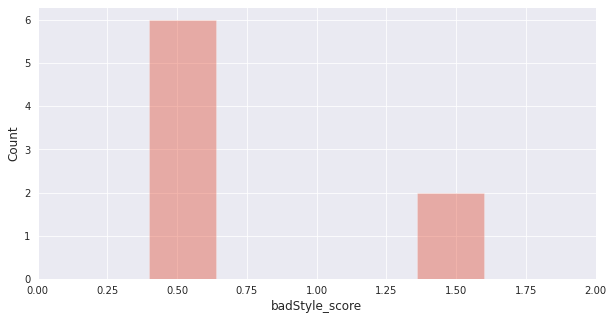

In [ ]:
##Visualizing style factor results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
plt.xlim(0,2)
sns.distplot(ensemble_df_detailed['badStyle_score'],bins=5,kde=False)
plt.xlabel('badStyle_score')
plt.ylabel('Count')
plt.show()

The above plot tells us that majority of the articles are genuine with badStyle_score of 0.50

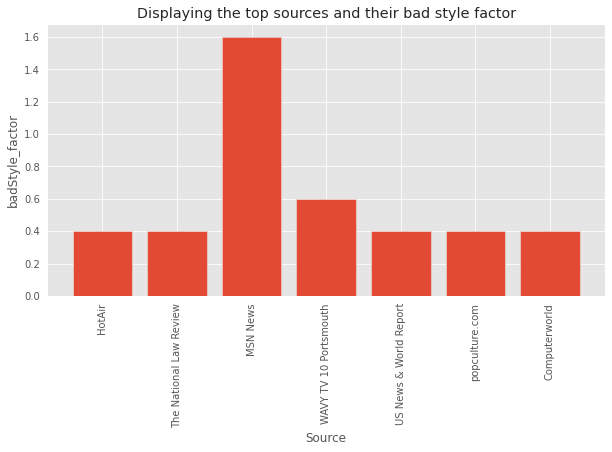

In [ ]:
##Displaying the sources and their bad style factor
plt.figure(figsize=(10,5))
test_df = ensemble_df_detailed
plt.bar(test_df['Source'], test_df['badStyle_score'])
plt.xticks(rotation=90)
plt.title('Displaying the top sources and their bad style factor')
plt.xlabel('Source')
plt.ylabel('badStyle_factor')
plt.show()

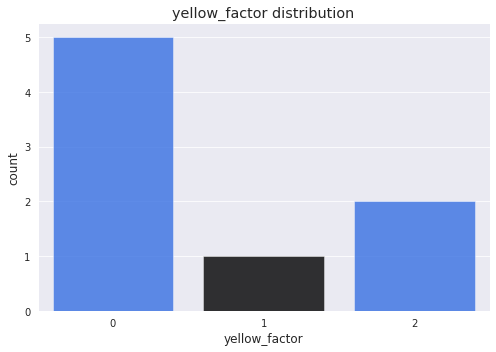

In [ ]:
#yellow_factor countplot
#visualizing yellow_factor frequency of dataset
sns.set_style('darkgrid')
plt.figure(figsize=(7,5))
fig1=sns.countplot(ensemble_df_detailed['yellow_factor'], alpha =.80, palette= ['#1a66ff','black'])
plt.title('yellow_factor distribution')
plt.tight_layout()
plt.show()

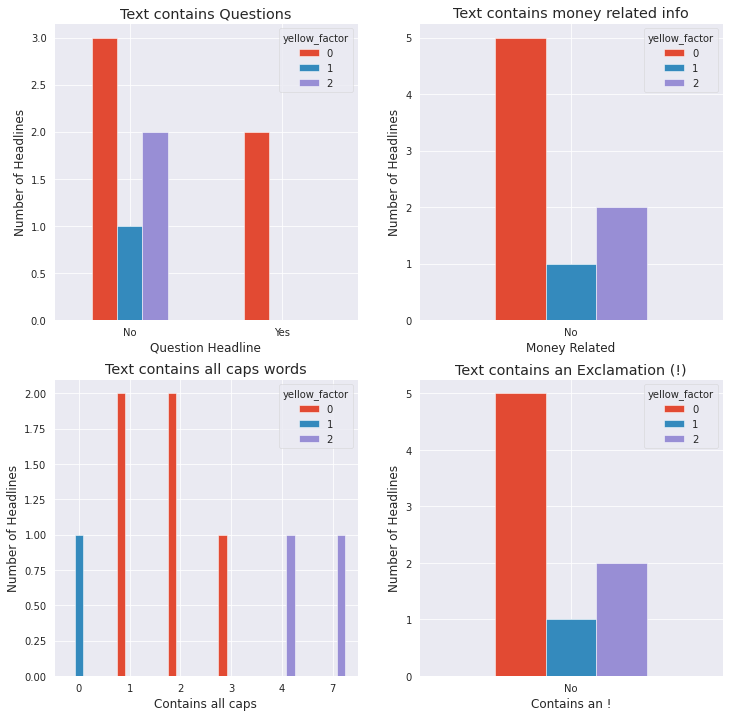

In [ ]:
#plotting engineered features to compare by yellow_factor 
import matplotlib.pyplot as plt
from matplotlib import style
sns.set_style('darkgrid')

figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

plot = ensemble_df_detailed.groupby('is_q')['yellow_factor'].value_counts().unstack().plot.bar(ax=axes[0,0], rot=0)
plot.set_xlabel('Question Headline')
plot.set_ylabel('Number of Headlines')
plot.set(xticklabels=['No','Yes'])
plot.set_title('Text contains Questions')

plot = ensemble_df_detailed.groupby('is_money')['yellow_factor'].value_counts().unstack().plot.bar(ax=axes[0,1], rot=0)
plot.set_xlabel('Money Related')
plot.set(xticklabels=['No','Yes'])
plot.set_ylabel('Number of Headlines')
plot.set_title('Text contains money related info')

plot = ensemble_df_detailed.groupby('All_Caps')['yellow_factor'].value_counts().unstack().plot.bar(ax=axes[1,0], rot=0)
plot.set_xlabel('Contains all caps')
plot.set_ylabel('Number of Headlines')
# plot.set(xticklabels=['No','Yes'])
plot.set_title('Text contains all caps words')

plot = ensemble_df_detailed.groupby('is_exclam')['yellow_factor'].value_counts().unstack().plot.bar(ax=axes[1,1], rot=0)
plot.set_xlabel('Contains an !')
plot.set_ylabel('Number of Headlines')
plot.set(xticklabels=['No','Yes'])
plot.set_title('Text contains an Exclamation (!)')

style.use('ggplot')
plt.show()

* The first row plots are not accurate since we expect question marks and money related details to be present in articles with yellow_factor = 2. 
* In the bottom left plot, we can see how ALL_CAPS words are mainly present in moderately and highly yellow articles only, and no ALL_CAPS words in least yellow articles.

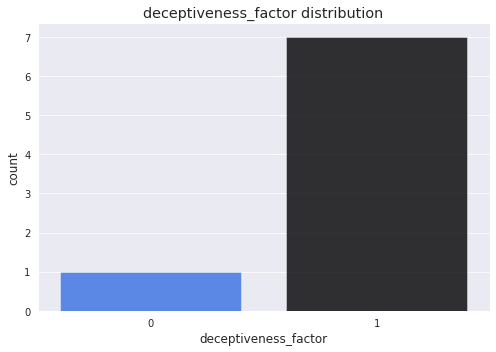

In [ ]:
#deceptiveness_factor countplot
#visualizing deceptiveness_factor frequency of dataset
sns.set_style('darkgrid')
plt.figure(figsize=(7,5))
fig1=sns.countplot(ensemble_df_detailed['deceptiveness_factor'], alpha =.80, palette= ['#1a66ff','black'])
plt.title('deceptiveness_factor distribution')
plt.tight_layout()
plt.show()

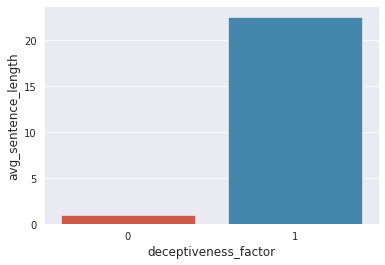

In [ ]:
##Creating a dataframe with unique sources and its average deceptive values
deceptiveness_df_avgSent = (
    ensemble_df_detailed
    .groupby('deceptiveness_factor')
    .agg({"avg_sentence_length":"mean"})
    .sort_values('avg_sentence_length', ascending=False)
    .reset_index()
)
ax = sns.barplot(x="deceptiveness_factor", y="avg_sentence_length", data=deceptiveness_df_avgSent)

The above plot says that the average sentence length is longer in deceptive news articles, but this is incorrect as suggested by the reference paper. 

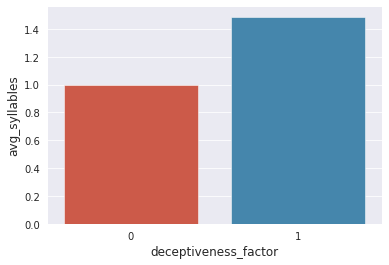

In [ ]:
##Creating a dataframe with unique sources and its average deceptive values
deceptiveness_df_avgSyllables = (
    ensemble_df_detailed
    .groupby('deceptiveness_factor')
    .agg({"avg_syllables":"mean"})
    .sort_values('avg_syllables', ascending=False)
    .reset_index()
)
ax = sns.barplot(x="deceptiveness_factor", y="avg_syllables", data=deceptiveness_df_avgSyllables)

Average syllables per word is higher in deciever and lower in truthful news articles as per the paper and our prediction. This matches

## **References**
* https://algotrading101.com/learn/sentiment-analysis-python-guide/
* https://github.com/Lucas170/Sentiment-Analysis-1-TSLA-Headlines
* https://github.com/AlisonSalerno/clickbait_detector
* https://github.com/aarsanjani/applied-ml-2020/blob/master/MullerLoop.ipynb
* https://github.com/dhrushilbadani/YellowFever
* https://pypi.org/project/textstat/

